# BM40A1401 GPU Computing

## Erik Kuitunen

### Exercise 3

In [33]:
import cupy as cp
import numpy as np 
import matplotlib.pyplot as plt 
import time

#### Task 1
Both NumPy and CuPy offer the linear algebra functions  linalg.norm() to get the norm and linalg.qr() to get the QR decomposition of matrices.

Time their performance against different sizes of square matrices.

Creating data and perfroming the calculations

In [34]:
N_elems = [ 10, 100, 250, 500, 1000, 1500 ] 

times_cpu = np.zeros( ( np.size( N_elems ), 2 ) )
times_gpu = np.zeros( ( np.size( N_elems ), 2 ) )

for jj in range( 100 ):
    ii = 0
    for elem in N_elems:
        
        # CPU measurements
        a_cpu = np.random.randn( elem, elem )
        
        start_time = time.perf_counter()
        res = np.linalg.norm( a_cpu )
        end_time = time.perf_counter()

        times_cpu[ ii, 0 ] = ( end_time - start_time )*1000
        
        start_time = time.perf_counter()
        res = np.linalg.qr( a_cpu )
        end_time = time.perf_counter()

        times_cpu[ ii, 1 ] += ( end_time - start_time )*1000
        
        
        # GPU measurements
        a_gpu = cp.random.randn( elem, elem )
        
        start_time = time.perf_counter()
        res = cp.linalg.norm( a_gpu )
        end_time = time.perf_counter()
        
        times_gpu[ ii, 0 ] = ( end_time - start_time )*1000
        
        start_time = time.perf_counter()
        res = cp.linalg.qr( a_gpu )
        end_time = time.perf_counter()
        
        times_gpu[ ii, 1 ] += ( end_time - start_time )*1000
        
        ii += 1
    
times_cpu = times_cpu / 100
times_gpu = times_gpu / 100

Visualizing results

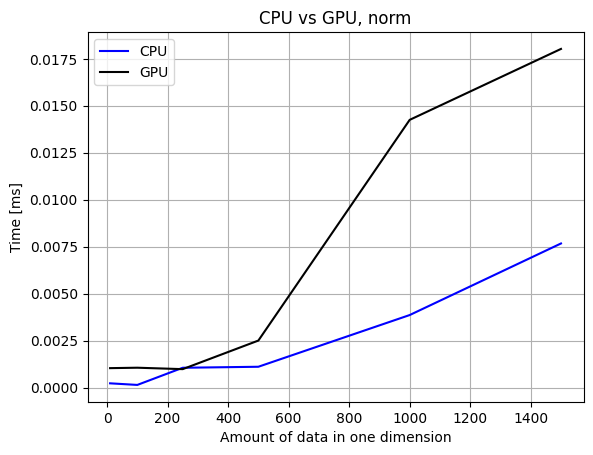

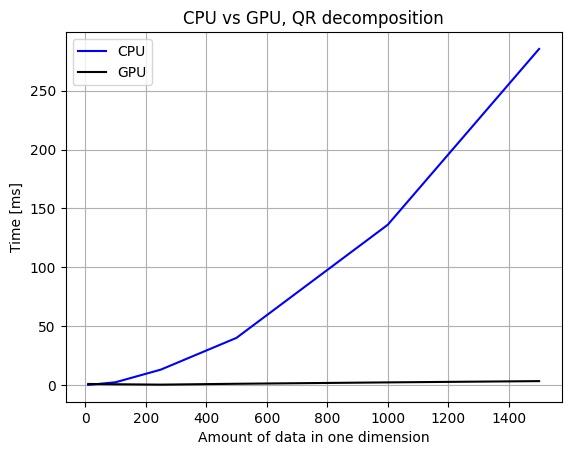

In [35]:
plt.plot( N_elems, times_cpu[ :, 0 ], 'b', label = "CPU" )
plt.plot( N_elems, times_gpu[ :, 0 ], 'k', label = "GPU")

plt.title( "CPU vs GPU, norm")
plt.xlabel( 'Amount of data in one dimension' )
plt.ylabel( 'Time [ms]' )
plt.legend( loc = "upper left" )
plt.grid()

plt.show()

plt.plot( N_elems, times_cpu[ :, 1 ], 'b', label = "CPU")
plt.plot( N_elems, times_gpu[ :, 1 ], 'k',label = "GPU")

plt.title( "CPU vs GPU, QR decomposition")
plt.xlabel( 'Amount of data in one dimension')
plt.ylabel( 'Time [ms]' )
plt.legend( loc = "upper left" )
plt.grid()

plt.show()

#### Task 2
Implement vector addition using NumPy, CuPy and an example kernel used in previous exercises. Time their performance against different vector sizes.

In [36]:
import pycuda.autoinit
import pycuda.driver as cuda
from pycuda.compiler import SourceModule

N_elems = [ 100, 10**3, 10**4, 10**5, 10**6, 5*10**6, 10**7 ] 

times_numpy = np.zeros( ( np.size( N_elems ), 1 ) )
times_cupy = np.zeros( ( np.size( N_elems ), 1 ) )
times_kernel = np.zeros( ( np.size( N_elems ), 1 ) )

The same N vector as in previous task will be used. 

Functions and kernel:

In [37]:

# NumPy vector addition
def vecAdd_numpy( a, b ):
    
    vector_length = np.size(a)
    #c = np.zeros( ( vector_length, 1) )

    c = a + b
    #for ii in range( vector_length ):
    #    c[ ii ] = a[ii] + b[ii]
    return c

# CuPy vector addition
def vecAdd_cupy( a, b ):
    
    #vector_length = cp.size(a)
    #c = cp.zeros( ( vector_length, 1) )

    c = cp.add( a, b )
    
# PyCUDA vector addition
modd = SourceModule("""
  __global__ void vector_addition( double* a, double* b, double* c, int n_elem) {

    for ( int i = threadIdx.x + blockIdx.x * blockDim.x; 
          i < n_elem; 
          i += gridDim.x * blockDim.x ) {
            
        c[i] = a[i] + b[i];
    
    }
  }
""")

NumPy calculations

In [38]:
for ii in range( 100 ):
    jj = 0
    for elems in N_elems: 
        
        a = np.random.randn( elems, 1 ).astype( float )
        b = np.random.randn( elems, 1 ).astype( float )
        
        # Calling NumPy function and saving result
        start_time = time.perf_counter()
        res = vecAdd_numpy( a, b )
        end_time = time.perf_counter()
        times_numpy[ jj ] += ( end_time - start_time )*1000
        
        jj += 1
        
times_numpy = times_numpy/100

CuPy calculations

In [39]:
for ii in range( 100 ):
    jj = 0
    for elems in N_elems:
        
        a = cp.random.randn( elems, 1 ).astype( float )
        b = cp.random.randn( elems, 1 ).astype( float )
        
        # Calling CuPy function and saving result
        start_time = time.perf_counter()
        res = vecAdd_cupy( a, b )
        end_time = time.perf_counter()
        times_cupy[ jj ] += ( end_time - start_time )*1000
        
        jj += 1
        
times_cupy = times_cupy/100

PyCUDA calculations

In [40]:


for ii in range( 100 ):
    jj = 0
    for elems in N_elems:
        
        a = np.random.randn( elems, 1 ).astype( float )
        b = np.random.randn( elems, 1 ).astype( float )
        
        block_dims = ( 1024, 1, 1 )
        grid_dims = ( int( np.ceil( elems / 1024 ) ), 1, 1 )
        
        a_gpu = cuda.mem_alloc( a.size * a.dtype.itemsize )
        cuda.memcpy_htod( a_gpu, a )

        b_gpu = cuda.mem_alloc( a.size * a.dtype.itemsize )
        cuda.memcpy_htod( b_gpu, b )

        c = np.empty_like(a)
        c_gpu = cuda.mem_alloc( a.size * a.dtype.itemsize )
        
        kernel = modd.get_function( "vector_addition" )
        
        start_time = time.perf_counter()
        kernel( a_gpu, b_gpu, c_gpu, np.int32( elems ), block = block_dims, grid = grid_dims )
        end_time = time.perf_counter()
        times_kernel[ jj ] += ( end_time - start_time )*1000
        
        cuda.memcpy_dtoh( c, c_gpu )
        
        jj += 1
        
times_kernel = times_kernel/100
        

Visualizing results

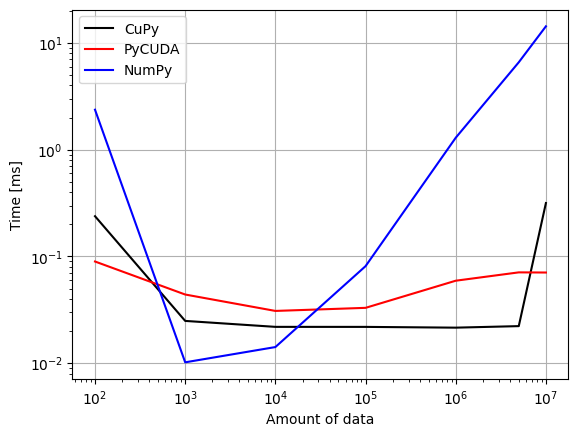

In [41]:
plt.xscale( "log" )
plt.yscale( "log" )
plt.plot( N_elems, times_cupy, 'k', label = "CuPy")
plt.plot( N_elems, times_kernel, 'r', label = "PyCUDA")
plt.plot( N_elems[ 0:np.size( times_numpy ) ], times_numpy, 'b', label = "NumPy" )
plt.xlabel( 'Amount of data' )
plt.ylabel( 'Time [ms]' )
plt.legend( loc = "upper left" )
plt.grid()

plt.show()



#### Task 3
Implement matrix multiplication using NumPy, CuPy and an example kernel used in previous exercises. Time their performance against different matrix sizes.



Initializing data and defining functions and kernel to be called

In [42]:
N_elems = [ 100, 250, 500, 1000, 1500, 2000 ] 
N_elems_gpu = [ 100, 250, 500, 1000, 1500, 2000, 3000, 4000 ] 

times_numpy = np.zeros( ( np.size( N_elems ), 1 ) )
times_cupy = np.zeros( ( np.size( N_elems_gpu ), 1 ) )
times_kernel = np.zeros( ( np.size( N_elems_gpu ), 1 ) )

def matmul_numpy( A, B ):
    
    C = np.matmul( A, B )
    
    return C

def matmul_cupy( A, B ):
    
    C = cp.matmul( A, B )
    
    return C

kernel_code_template = """
  __global__ void matmul_sharedmem( const float* A, const float* B, float* C, int M, int N, int K, int n_tiles ) {
    
    float C_elem = 0;
    
    // Block indices, each block computes submatrix of C, C_sub
    int block_row = blockIdx.y;
    int block_col = blockIdx.x;
    
    // Thread indices. Each thread computes an element of C_sub
    int thread_row = threadIdx.y;
    int thread_col = threadIdx.x;

    // Looping through relevant submatrices to compute C_sub
    for (int ii = 0; ii < n_tiles; ++ii ) { 
    
      // Loading submatrices from global memory
      int linear_ind_A = N * thread_row + thread_col + ii * %(TILE_WIDTH)s + block_row * %(TILE_WIDTH)s * N;
      int linear_ind_B = K * thread_row + thread_col + ii * %(TILE_WIDTH)s * K + block_col * %(TILE_WIDTH)s;
      
      // Shared memory for the submatrices of A and B
      __shared__ float A_sub[ %(TILE_WIDTH)s ][ %(TILE_WIDTH)s ];
      __shared__ float B_sub[ %(TILE_WIDTH)s ][ %(TILE_WIDTH)s ];
      
      // TODO check for threads outside matrix bounds
      
      A_sub[ thread_row ][ thread_col ] = A[ linear_ind_A ];
      B_sub[ thread_row ][ thread_col ] = B[ linear_ind_B ];
      
      __syncthreads();
      
      // Doing the actual multiplication of the submatrices
      for (int kk = 0; kk < %(TILE_WIDTH)s; ++kk) {
        
        float A_sub_elem = A_sub[ thread_row ][ kk ];
        float B_sub_elem = B_sub[ kk ][ thread_col ];
        
        C_elem += A_sub_elem * B_sub_elem;
        
      }
      
      __syncthreads();
    
    }
      
    // Saving the C_elem to matrix C
    int linear_ind_C = block_row * %(TILE_WIDTH)s * K + block_col * %(TILE_WIDTH)s + thread_row * K + thread_col;
    C[ linear_ind_C ] = C_elem;
    
  } 
"""

Timing numpy

In [43]:
for ii in range( 100 ):
    jj = 0
    for elems in N_elems:
        
        A = np.random.randn( elems, elems ).astype( float )
        B = np.random.randn( elems, elems ).astype( float )
        
        # Calling NumPy function and saving result
        start_time = time.perf_counter()
        res = matmul_numpy( A, B )
        end_time = time.perf_counter()
        times_numpy[ jj ] += ( end_time - start_time )*1000
        
        jj += 1
        
times_numpy = times_numpy/100
        
    

Timing CuPy

In [44]:
for ii in range( 100 ):
    jj = 0
    for elems in N_elems_gpu:
        
        A = cp.random.randn( elems, elems ).astype( float )
        B = cp.random.randn( elems, elems ).astype( float )
        
        # Calling CuPy function and saving result
        start_time = time.perf_counter()
        res = matmul_cupy( A, B )
        end_time = time.perf_counter()
        times_cupy[ jj ] += ( end_time - start_time )*1000
        
        jj += 1
        
times_cupy = times_cupy/100

Timing PyCUDA kernel

In [45]:
TILE_WIDTH = 16

kernel_code = kernel_code_template % {
        'TILE_WIDTH': TILE_WIDTH
        }
mod = SourceModule( kernel_code )
matriximul = mod.get_function( "matmul_sharedmem" )

for ii in range( 100 ):
    jj = 0
    for elem in N_elems_gpu:
        
        # Creating data, initializing thread and block sizes
        A = np.float32( np.random.rand( elem, elem ) )
        B = np.float32( np.random.rand( elem, elem ) )

        gridDim = int( np.ceil( elem/TILE_WIDTH ) )
        block_dims = ( TILE_WIDTH, TILE_WIDTH, 1 )
        grid_dims = ( gridDim, gridDim, 1 )
        
        # Allocating memory and copying data from host to device
        A_gpu = cuda.mem_alloc( A.nbytes )
        cuda.memcpy_htod( A_gpu, A )

        B_gpu = cuda.mem_alloc( B.nbytes )
        cuda.memcpy_htod( B_gpu, B )

        C = np.empty( [ A.shape[0], B.shape[1] ], dtype = np.float32 )
        C_gpu = cuda.mem_alloc( C.nbytes )
        
        # Call the kernel
        dim = np.int32( elem )
        tiles = np.int32( np.ceil( elem/TILE_WIDTH))
        
        start_time = time.perf_counter()
        matriximul( A_gpu, B_gpu, C_gpu, dim, dim, dim, tiles,
                   block = block_dims, grid = grid_dims )
        end_time = time.perf_counter()
        times_kernel[ jj ] += ( end_time - start_time )*1000
        
        cuda.memcpy_dtoh( C, C_gpu )
        
        jj += 1
        
times_kernel = times_kernel/100    

Visualizing results

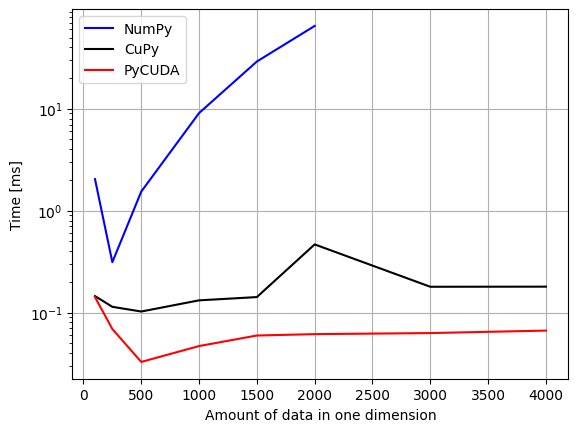

In [46]:
plt.plot( N_elems, times_numpy, 'b', label = "NumPy" )
plt.plot( N_elems_gpu, times_cupy, 'k', label = "CuPy" )
plt.plot( N_elems_gpu, times_kernel, 'r', label = "PyCUDA" )

plt.yscale( "log" )

plt.xlabel( 'Amount of data in one dimension' )
plt.ylabel( 'Time [ms]' )
plt.legend( loc = "upper left" )
plt.grid()

plt.show()